In [1]:
import re
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit

%matplotlib inline

from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image
import urllib

from sklearn.metrics import accuracy_score
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook as tqdm

import matplotlib
%matplotlib inline

http://scikit-learn.org/stable/modules/feature_extraction.html

# Чтение данных

In [2]:
train = pd.read_csv('train.csv', encoding='utf_8')
test = pd.read_csv('test.csv')

train.shape, test.shape

((30000, 4), (10000, 3))

In [3]:
set(train['sentiment'])

{'anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry'}

In [4]:
sent_dict = {'neutral'    : 0,
             'anger'      : 1,
             'boredom'    : 2,
             'empty'      : 3,
             'enthusiasm' : 4,
             'fun'        : 5,
             'happiness'  : 6,
             'hate'       : 7,
             'love'       : 8,
             'relief'     : 9,
             'sadness'    : 10,
             'surprise'   : 11,
             'worry'      : 12}
sent_dict_back = {v: k for k, v in sent_dict.items()}

In [5]:
train['sent_enc'] = train['sentiment'].replace(sent_dict)

In [6]:
train.sample(15)

,Unnamed: 0,author,content,sentiment,sent_enc
12314,17314,itchyblood,Why is no one online?,surprise,11
13075,9725,tjbladez,pulled from interesting meeting to an urgent s...,surprise,11
13905,33518,LaBeautifulMess,"Happy Mother's Day to everyone's mothers, moth...",love,8
25520,9460,scamby1,Car shopping with kacy yay,happiness,6
7679,10001,Lulacumplido,"ahhhh, very sad",worry,12
22789,17358,Aprilmclean,@Karetron I KNOW!!!! Its all stormy outside.. ...,love,8
20120,10077,marktrout,is in mourning that he is having to miss the h...,sadness,10
13019,23739,chaosbot,"Not to worry, noone got that one. Next questio...",surprise,11
807,28354,hayesdev,TextMate crashed for the first time in 3 month...,relief,9
13004,31938,rrbaker,"@eclip5e Good lord, man. I recommend the Dar...",worry,12


In [7]:
len(set(train['author']))

26148

In [8]:
test.sample(15)

,id,author,content
2802,24867,babybucket,"@Runningfrommich, &lt;3 x9999999."
5922,6529,Explosivpotato,Smart cars are the most worthless cars ever ma...
3047,2135,anthraxmoh,My stomach is all EXPLODE from the wendys why...
9815,38625,natroksjayz,so this my last week of school then finals yesss
7830,35741,unitechy,@adityamishra yeah next time
8595,353,Fredrikkk,english class! working on interactive orals
994,38260,dibbbles,"@Parsnipzilla ohtays, it all makes sense now....."
895,39139,pr0mythius,if you hit a car .. u should leave a note http...
9930,35403,Obsessee,@oscarrplz thanks oscc i have been changing i...
6033,3211,quickquacker,"my littelist fish, udon, is dearly departed"


In [9]:
def transm(x):
        
    x = list(filter(None, x.split(' ')))
    x = list(filter(lambda word: word[0] != '@', x))
    x = list(filter(lambda word: word[:4] != 'http', x))
    x = list(filter(lambda word: len(word) >= 1, x))
    x = [''.join([i for i in word]).lower() for word in x]
    x = list(filter(None, x))
           
    return ' '.join(x)

In [10]:
happy_words = set([])#'yes', 'ok', 'good', 'best', 'well', 'laughing', 'wonderful', 'very', ' too', 'haha',
#                  'ha', 'hah', 'hahaha', 'happy', 'really', 'realy', 'xD', ':)', ':-)', 'x)', '8D', ':D',
#                  'nice', 'thank', 'laugh', 'laughing', 'laughed', 'surprise', 'luck', 'surprise', 'great',
#                  'crazy', 'totally', 'lol', ' hi', 'hello', 'much', ' so', 'ohh', 'awesome', 'cool',
#                  'love', 'like', ';3', ':3', 'smile', 'yum', 'such', 'at all', 'lala', 'joy', ' up', 'cheer',
#                   'better', 'huh', 'feel'])

sadness_words = set([])#'down', 'please', 'sorry', 'rip', 'ugh', 'suck', 'bored', 'wanna', 'poor', 'shame', 
#                     'bad', 'sad', 'unhappy', 'study', 'teach', 'fall', 'off', 'fail', ' um',
#                    'why', "don't", ' no', 'fuck', 'miss', 'hate', 'hmm', 'wish', 'tire', 'terrible', 'awful',
#                    'hurt', 'didn', 'doesn', 'cry', 'cri', 'lost', 'nothin', 'lonely', 'alone', 'not', 'last',
#                     'slow', ' bor', 'stupid', 'ugly', 'bad', ' die', 'cant', 'already', 'but', 'busy', 'dead', 
#                    'sick', ' aww', 'exam', ' tir', 'less', ' out', 'anymore', 'shit', 'terrible', 'annoy', 
#                     'leave'])

fun_words = set([])#'hey', 'yup', 'waaah'])

In [11]:
list(train[train['sentiment'] == 'fun']['content'].sample(15))

['@caramp lol you saw where I was going with that...both of my last names are to common nothing special on me',
 '@google aahh google, you never fail to make me smile http://twitpic.com/4w9rp (via @richiban)',
 'I want to go to Universal too!',
 "&quot;Thick as pig shit - went to Oxford&quot; - Helena's (Cantab) friend's description of me to her boyfriend, yesterday...",
 "@alivicwil She's so funny!!! I wish she were my grandma",
 "@merdujapon Really all that? I'll look for it and will report back",
 'Hey @robluketic Bye Bye  was fun too   (robluketic live &gt; http://ustre.am/2w5v)',
 '@ajaimk Also, HAPPY STAR WARS DAY!!!',
 '@euripidean bank holiday is going well, had a great band practice so still on a buzz',
 '08.05.09 partying at the Pineforest  http://tinyurl.com/ojugsb',
 '@CeesDope_  ahhhhaaa bangbros.com! psshh nigga its all about onionbooty.com',
 "@BrisvegasLukass yes I do! I'll try posting some pics when I can",
 "@PaperCakes lol, I haven't made anything yet, I've just spre

In [12]:
def transm_emoticon(x):
    
    was_exclamation = 0
    was_question = 0
    was_dot = 0
    was_comma = 0
    was_appeal = 0
    was_brace1 = 0
    was_brace2 = 0
    upper_cased = 0
    
    for letter in x:
        if letter == '?':
            was_question += 1
        if letter == '!':
            was_exclamation += 1
        if letter == '.':
            was_dot += 1
        if letter == ',':
            was_comma += 1
        if letter == '@':
            was_appeal += 1
        if letter == '(':
            was_brace1 += 1
        if letter == ')':
            was_brace2 += 1
        if letter.isupper():
            upper_cased += 1
         
    ans = dict()
  
    x = list(filter(None, x.split(' ')))
    x = list(filter(lambda word: word[0] != '@', x))
    x = list(filter(lambda word: word[:4] != 'http', x))
    
    x = list(filter(lambda word: len(word) >= 1, x))
    x = [''.join([i for i in word]).lower() for word in x]
    x = list(filter(None, x))
    
    xx = ' '.join(x)
    
    for happy_word in happy_words:
        if xx.find(happy_word) != -1:
            ans['happiness_' + happy_word] = 1
            
    for sad_word in sadness_words:
        if xx.find(sad_word) != -1:
            ans['sadness_' + sad_word] = 1
    
    for fun_word in fun_words:
        if xx.find(fun_word) != -1:
            ans['sadness_' + fun_word] = 1
    
    ans['???'] = was_question
    ans['!!!'] = was_exclamation
    ans['...'] = was_dot
    ans[',,,'] = was_comma
    ans['@@@'] = was_appeal
    ans['((('] = was_brace1
    ans[')))'] = was_brace2
    ans['#upper_cased'] = upper_cased / (0.5 + len(xx))
    
    ans['#wordcount'] = len(x)
    ans['#lettercount'] = len(xx)
    
    return ans

In [13]:
phrase = train['content'][5471]
print(phrase)
phrase2 = train['content'][25472]
print(phrase2)
phrase3 = 'Hey! I''m here, thank you 123 hello!'
print(phrase3)
phrase4 = test['content'][4658]
print(phrase4)

@jishanvn yï¿½n tï¿½m, sang n?m s? th?y ti?t m?c Tr?n tinh twitter tr? l?i Lï¿½ Thï¿½ng , Th?ch Sanh nh? lï¿½m quiz mï¿½ c??i ???c cï¿½ng chï¿½a
@enjoymore Your cave? Does it have an espresso machine?
Hey! Im here, thank you 123 hello!
http://twitpic.com/4jacy - the lovelies ms @angieange rane &amp; i


In [14]:
phrase = 'Hey! I''M HERE, thank you 123 hello!'
transm_emoticon(phrase)

{'!!!': 2,
 '#lettercount': 34,
 '#upper_cased': 0.2028985507246377,
 '#wordcount': 7,
 '(((': 0,
 ')))': 0,
 ',,,': 1,
 '...': 0,
 '???': 0,
 '@@@': 0}

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vectorizer = CountVectorizer()
vectorizer 

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
train_corpus = list(train['content'].apply(transm))
test_corpus  = list(test ['content'].apply(transm))

In [24]:
train_corpus[700:710]

["check out the conchords 'business time'",
 'i know, but i wanna finish bsg first',
 'hey im back i replyed xxx',
 'those dog pic had me rolf! the one with the snow stuck too it has that &quot;if looks could kill look&quot; way funny',
 "i have the best bestfriend in the whole world .. my mother's day present = ambien, klonopin and a quarter! woohoo! smh...",
 'yess! talking 2 a hott guy! happy ass fuk!',
 'back at work',
 "woot! lol it's gonna be hard to send this one back",
 'one of my besties is moving away',
 "i can't believe clinton and bush were both here, doing a seminar together and i did not go"]

In [25]:
test_corpus[:10]

['good morning',
 "i just put my computer up on craigslist. i've had the same case, monitor, and speakers for over 5 years.",
 'in ten minutes shopping demi lovato-back around demi lovato-behind enemy lines have you all seen the titanic 2 trailer? its really good!',
 'from twitterberry moved to ubertwitter - suffered from bb cache errors',
 'tear*',
 'ps... i got ben button today... completes my best picture noms....got all 5 now. it was a great year!!',
 'just fell asleep for 2 &amp; 1/2 hours so missed both chances for first-look hollyoaks, ugh',
 'thank ye, vaneta. much appreciated',
 'oh noes!! melted ice cream = do not want.',
 'i just had pasta from pizzahut.']

In [26]:
vectorizer = vectorizer.fit(train_corpus)
X_train_counted = vectorizer.transform(train_corpus)
X_test_counted  = vectorizer.transform(test_corpus)

In [27]:
tfidf_vect = TfidfVectorizer(smooth_idf=True, min_df=0.000005)
tfidf_vect = tfidf_vect.fit(train_corpus)

In [28]:
X_train = X_train_counted
# X_train = tfidf_vect.transform(train_corpus)
X_test  = X_test_counted
# X_test  = tfidf_vect.transform(test_corpus)

In [29]:
X_train.shape, X_test.shape

((30000, 25685), (10000, 25685))

In [30]:
train_custom = pd.DataFrame(list(train['content'].apply(transm_emoticon))).fillna(0)
train_custom.head()

,!!!,#lettercount,#upper_cased,#wordcount,(((,))),",,,",...,???,@@@
0,0,93,0.000000,18,0,0,3,0,0,1
1,1,86,0.034682,18,0,0,1,1,0,1
2,0,10,0.000000,2,0,0,0,0,2,1
3,1,132,0.067925,26,0,0,1,1,2,0
4,0,61,0.065041,11,0,0,1,2,0,0


In [31]:
test_custom = pd.DataFrame(list(test['content'].apply(transm_emoticon))).fillna(0)
test_custom.head()

,!!!,#lettercount,#upper_cased,#wordcount,(((,))),",,,",...,???,@@@
0,0,12,0.160000,2,0,0,0,0,0,0
1,0,104,0.019139,20,0,0,2,2,0,0
2,1,136,0.000000,22,0,0,0,0,1,0
3,0,70,0.042553,11,0,0,0,0,0,0
4,0,5,0.727273,1,0,0,0,0,0,1


In [32]:
X_train.shape, np.array(train_custom.values).shape, X_test.shape, np.array(test_custom.values).shape

((30000, 25685), (30000, 10), (10000, 25685), (10000, 10))

In [33]:
import scipy.sparse

In [34]:
X_train = scipy.sparse.hstack((X_train, np.array(train_custom.values)))
X_test  = scipy.sparse.hstack((X_test,  np.array(test_custom.values)))

In [35]:
y_train = train['sent_enc']

In [36]:
X_train.shape, y_train.shape, X_test.shape

((30000, 25695), (30000,), (10000, 25695))

In [37]:
cv_strategy = ShuffleSplit(n_splits=5, test_size=0.2, random_state=33)

good : `LogisticRegression(penalty='l1', C=1)`

In [32]:
# for kernel in ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']:
#     for C in tqdm([0.5, 0.7, 0.9, 1.0, 1.1, 1.2, 1.3]):
#         estimator = LogisticRegression(penalty='l2', C=C, solver=kernel)#SGDClassifier(max_iter=10000, tol=0.1, penalty='elasticnet', alpha=0.1)
#         scoring = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv_strategy, verbose=3, n_jobs=3)
#         print('c:', C, 'kernel:', kernel, 'score:', scoring.mean())

In [72]:
c: 1.3 kernel: liblinear score: 0.346633333333
c: 1.1 kernel: sag score: 0.346566666667
c: 1.1 kernel: saga score: 0.346666666667
c: 1.1 kernel: lbfgs score: 0.3465

SyntaxError: invalid syntax (<ipython-input-72-a62ec3d5ebb9>, line 1)

In [38]:
cv_strategy = ShuffleSplit(n_splits=10, test_size=0.2)#, random_state=33)

# logReg

In [39]:
estimator = LogisticRegression(penalty='l1', C=0.45, tol=0.00027, solver='liblinear', max_iter=10500)#SGDClassifier(max_iter=10000, tol=0.1, penalty='elasticnet', alpha=0.1)
scoring = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv_strategy, verbose=3, n_jobs=3)
print('score:', scoring.mean())

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................... , score=0.3575, total=  22.9s
[CV]  ................................................................
[CV] ...................... , score=0.36083333333333334, total=  26.1s
[CV]  ................................................................
[CV] .................................... , score=0.361, total=  30.8s
[CV]  ................................................................
[CV] .................................... , score=0.359, total=  21.2s
[CV]  ................................................................
[CV] ...................... , score=0.35333333333333333, total=  23.4s
[CV]  ................................................................
[CV] ................................... , score=0.3575, total=  22.9s
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.4min finished


In [80]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
from sklearn.metrics import confusion_matrix

X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train, test_size=0.2)
estimator.fit(X_subtrain, y_subtrain)
subpred = estimator.predict(X_subtest)

Confusion matrix, without normalization
Normalized confusion matrix


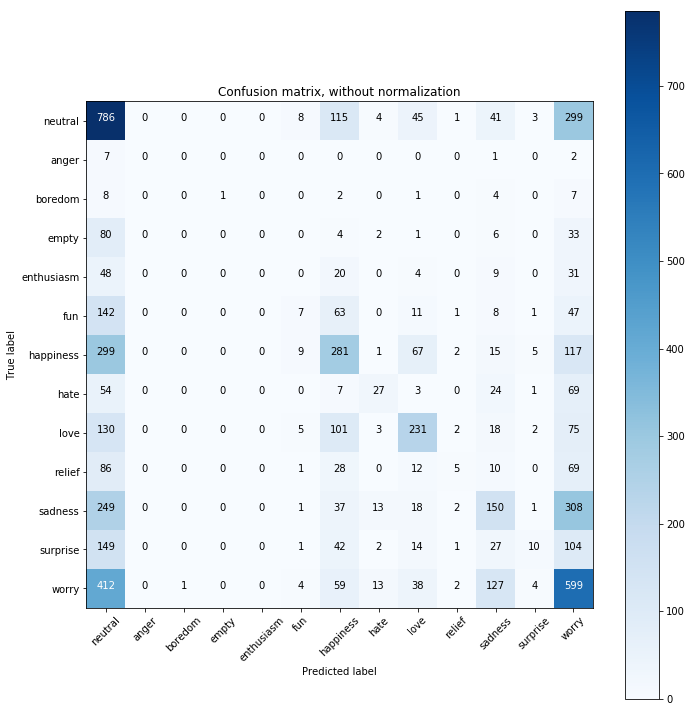

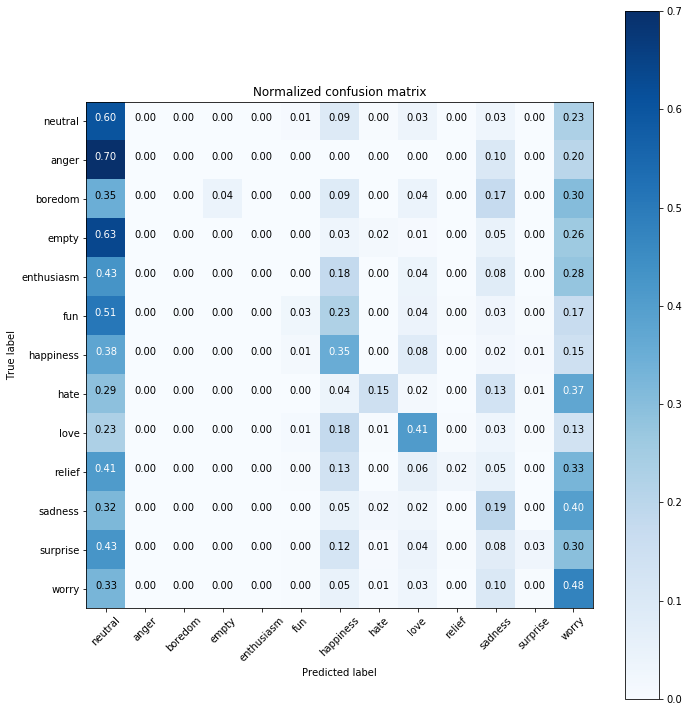

In [82]:
class_names =sent_dict.keys()

cnf_matrix = confusion_matrix(y_subtest, subpred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# SVC

In [62]:
estimator = LinearSVC(penalty = 'l1', dual=False, C=0.45, tol=0.001)
scoring = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv_strategy, verbose=3, n_jobs=3)
print('score:', scoring.mean())


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=0.35433333333333333, total=  42.8s
[CV]  ................................................................
[CV] ....................... , score=0.3571666666666667, total=  54.9s
[CV]  ................................................................
[CV] ....................... , score=0.3586666666666667, total=  56.4s
[CV]  ................................................................
[CV] ................................... , score=0.3635, total=  49.9s
[CV]  ................................................................
[CV] ....................... , score=0.3641666666666667, total=  56.8s
[CV]  ................................................................
[CV] ................................... , score=0.3615, total= 1.0min
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  3.1min finished


# SGD

In [68]:
estimator = SGDClassifier(max_iter=50, tol=0.0001, penalty='l2', alpha=0.00002)
scoring = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv_strategy, verbose=3, n_jobs=3)
print('score:', scoring.mean())

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


/home/celidos/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV] ...................... , score=0.12016666666666667, total=   4.3s
[CV]  ................................................................


/home/celidos/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV] ..................................... , score=0.17, total=   5.3s
[CV]  ................................................................


/home/celidos/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV] .................................... , score=0.167, total=   6.0s
[CV]  ................................................................


KeyboardInterrupt: 

# Predict with the best

In [40]:
from sklearn.model_selection import cross_val_predict

In [41]:
estimator.fit(X_train, y_train)

LogisticRegression(C=0.45, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10500, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.00027,
          verbose=0, warm_start=False)

In [42]:
# cross_val_predict(estimator, X_train, y_train)

In [42]:
test_predict=estimator.predict(X_test)

ans = pd.DataFrame()
ans['id'] = test['id']
ans['sentiment'] = test_predict
ans['sentiment'] = ans['sentiment'].replace(sent_dict_back)
ans.to_csv('ans_withoutkeyword.csv', sep = ',', index=False)

In [43]:
ans.head()

,id,sentiment
0,32823,neutral
1,16298,neutral
2,28505,happiness
3,6689,neutral
4,26893,neutral


# Подсчет количеств слов

In [103]:
all_words = set()
for phrase in list(train['content']):
    newlist = transm(phrase)
    all_words |= set(newlist)

In [104]:
len(all_words)

31

In [105]:
list(all_words)[:200]

['v',
 'b',
 'a',
 't',
 'o',
 'y',
 'h',
 'j',
 'f',
 'i',
 'k',
 'z',
 'g',
 'm',
 '!',
 '?',
 'ï',
 'r',
 'e',
 'w',
 'n',
 'q',
 'c',
 'â',
 'l',
 'd',
 'p',
 ' ',
 'u',
 's',
 'x']

In [69]:
ans1df = pd.read_csv('ans1.csv')
ans2df = pd.read_csv('ans2.csv')
# ans3df = pd.read_csv('ans3.csv')

In [70]:
ans1df.head()

,id,sentiment
0,32823,happiness
1,16298,worry
2,28505,happiness
3,6689,neutral
4,26893,neutral


In [71]:
ans2df.head()

,id,sentiment
0,32823,happiness
1,16298,worry
2,28505,happiness
3,6689,neutral
4,26893,neutral


In [72]:
# ans3df.head()

In [73]:
merged = pd.concat([ans1df, ans2df,], axis=1).drop(['id'], axis=1)
merged.columns = ['s1', 's2']

In [74]:
merged.head()

,s1,s2
0,happiness,happiness
1,worry,worry
2,happiness,happiness
3,neutral,neutral
4,neutral,neutral


In [75]:
def best_ans(x):
    data = Counter(list(x))
    common = data.most_common(1)[0][0]
    if common == 'neutral':
        if x['s1'] != 'neutral':
            common = x['s1']
            return common
        if x['s2'] != 'neutral':
            common = x['s2']
#         if x['s3'] != 'neutral':
#             common = x['s3']
    return common

In [76]:
merged.iloc[8]

s1      worry
s2    neutral
Name: 8, dtype: object

In [77]:
best_ans(merged.iloc[8])

'worry'

In [78]:
ans = pd.DataFrame()
ans['id'] = test['id']
# ans['sentiment'] = test_predict
ans['sentiment'] = merged.apply(best_ans, axis=1)#ans['sentiment'].replace(sent_dict_back)
ans.to_csv('ans4.csv', sep = ',', index=False)

In [79]:
ans.head()

,id,sentiment
0,32823,happiness
1,16298,worry
2,28505,happiness
3,6689,neutral
4,26893,neutral
